# Show Ratio Holo/Ronchi

- need to increase the number of files to be open:

    ulimit -a
    
    ulimit -n 2048
    
    ulimit -Sn 10000

In [2]:
!ulimit -a

core file size          (blocks, -c) 0
data seg size           (kbytes, -d) unlimited
file size               (blocks, -f) unlimited
max locked memory       (kbytes, -l) unlimited
max memory size         (kbytes, -m) unlimited
open files                      (-n) 2048
pipe size            (512 bytes, -p) 1
stack size              (kbytes, -s) 8192
cpu time               (seconds, -t) unlimited
max user processes              (-u) 1418
virtual memory          (kbytes, -v) unlimited


## Setup

### Notebook style

In [3]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

### import

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

import sys
import os
import pandas as pd
import glob
from matplotlib.backends.backend_pdf import PdfPages 

In [5]:
from scipy import interpolate

In [6]:
import seaborn as sns

In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Figure style

In [8]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),   #defines the default image size
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [9]:
plt.rcParams.update({'figure.max_open_warning': 0}) # to see a large number of files

## Initialisation

### Spectractor

In [10]:
PATH_SPECTRACTOR='../../Spectractor'
PATH_SPECTRACTORSIM='../../SpectractorSim'
PATH_GMAOMERRA='../merra2'

In [11]:
sys.path.append(PATH_SPECTRACTOR)
sys.path.append(PATH_SPECTRACTORSIM)
sys.path.append(PATH_GMAOMERRA)

In [12]:
from spectractor import *
from spectractorsim import *

## Input spectra

### LogBook

In [13]:
file_logbook_csv=os.path.join(PATH_SPECTRACTOR,'ctiofulllogbook_jun2017_v4.csv')

In [14]:
df_ctio_lbk=pd.read_csv(file_logbook_csv,sep=';')

In [15]:
df_ctio_lbk.columns

Index([u'Unnamed: 0', u'date', u'subdir', u'index', u'object', u'filter',
       u'disperser', u'airmass', u'exposure', u'focus', u'seeing', u'P', u'T',
       u'RH', u'W', u'file', u'Obj-posXpix', u'Obj-posYpix', u'Dx', u'Dy',
       u'comment', u'skip'],
      dtype='object')

In [16]:
df_ctio_lbk=df_ctio_lbk.reindex(columns=['date','index','P','T','RH','airmass','seeing','exposure','object','filter','disperser','focus','W','subdir','file']).set_index('date').sort_index()

### Spectra Data

In [17]:
home=os.getenv('HOME')

In [18]:
print home

/Users/dagoret


In [19]:
path_data=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod1')
#path_data=os.path.join('/sps/lsst/data/AtmosphericCalibration','CTIODataJune2017_reduced_RG715_v2_prod1')

In [20]:
All_Subdirs=np.array(['data_28may17','data_29may17','data_30may17','data_31may17','data_01jun17','data_02jun17',
            'data_03jun17','data_04jun17','data_06jun17','data_08jun17','data_09jun17','data_10jun17',
            'data_12jun17','data_13jun17'])

In [21]:
Flag_Photometric_Nights=np.array([False,False,True,False,False,False,False,False,False,True,False,True,True,False])

In [22]:
photometric_indexes=np.where(Flag_Photometric_Nights)[0]

In [23]:
print 'Photometric indexes : ',photometric_indexes

Photometric indexes :  [ 2  9 11 12]


In [24]:
print 'Photometric nights : ',All_Subdirs[photometric_indexes]

Photometric nights :  ['data_30may17' 'data_08jun17' 'data_10jun17' 'data_12jun17']


### Sim spectra

In [25]:
PATH_SPECTRACTORSIM

'../../SpectractorSim'

In [26]:
#path_sim=os.path.join(PATH_SPECTRACTORSIM,'sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra')
#path_sim=PATH_SPECTRACTORSIM+'/sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra'
path_sim=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra')
#path_sim="/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra"

In [27]:
path_sim

'/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra'

## Selection of night

In [28]:
date="20170529"

In [29]:
idx_sel_subdir=1

### Logbook

In [30]:
all_obs=df_ctio_lbk.loc[(df_ctio_lbk["subdir"]==All_Subdirs[idx_sel_subdir])].sort_index()

In [31]:
all_obs_extr=all_obs[["index","object"]]

### input spectra files

In [32]:
path_spectra=os.path.join(path_data,All_Subdirs[idx_sel_subdir])

In [33]:
search_string=os.path.join(path_spectra,'*.fits')
all_spectrafiles=glob.glob(search_string)
all_spectrafiles=sorted(all_spectrafiles)

In [34]:
all_spectrafiles[:5]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1/data_29may17/reduc_20170529_048_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1/data_29may17/reduc_20170529_049_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1/data_29may17/reduc_20170529_050_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1/data_29may17/reduc_20170529_051_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1/data_29may17/reduc_20170529_052_spectrum.fits']

### extract the index from the data spectra filename

In [35]:
def get_index_from_filename(ffilename,the_searchtag):
    fn=os.path.basename(ffilename)
    sel_index= int(re.findall(the_searchtag,fn)[0])
    return sel_index

In [36]:
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
all_sel_indexes=[]
for ffn in all_spectrafiles:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    all_sel_indexes.append(sel_index)
all_sel_indexes=np.array(all_sel_indexes)    

### extract the logbook rows corrsponding to the spectra

- use the indexes obtained to extract the relevant rows from the logbook

In [37]:
#SelFlag=[]
#for index, row in all_obs.iterrows():
#  if row["index"] in all_sel_indexes:
#    SelFlag.append(True)
#  else:
#    SelFlag.append(False)
#sel_obs=all_obs[SelFlag]

In [38]:
sel_obs=all_obs.loc[all_obs['index'].isin(all_sel_indexes)]

In [39]:
sel_obs.head()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-30T00:07:29.654,48,779,4,48,"1,049","1,199",60,HD111980,dia,Ron400,12400,"13,1",data_29may17,reduc_20170529_048.fits
2017-05-30T00:09:13.188,49,779,"3,9",48,"1,048","1,22",60,HD111980,dia,Ron400,12400,"9,3",data_29may17,reduc_20170529_049.fits
2017-05-30T00:11:05.597,50,779,4,48,"1,046","1,258",60,HD111980,dia,Thor300,12400,"8,5",data_29may17,reduc_20170529_050.fits
2017-05-30T00:12:49.126,51,779,"4,1",48,"1,044","1,127",60,HD111980,dia,Thor300,12400,"8,1",data_29may17,reduc_20170529_051.fits
2017-05-30T00:14:41.448,52,779,"4,1",47,"1,043","1,336",60,HD111980,dia,HoloPhP,12400,"8,7",data_29may17,reduc_20170529_052.fits


In [40]:
sel_obs.tail()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-30T02:43:12.845,78,779,"3,4",42,"1,102","1,39",360,HD111980,RG715,HoloPhAg,12500,"8,9",data_29may17,reduc_20170529_078.fits
2017-05-30T02:49:56.369,79,779,"3,6",40,"1,114","1,467",360,HD111980,RG715,HoloPhAg,12500,"10,3",data_29may17,reduc_20170529_079.fits
2017-05-30T02:56:48.654,80,779,"3,4",41,"1,128","2,524",360,HD111980,RG715,HoloAmAg,12500,"14,1",data_29may17,reduc_20170529_080.fits
2017-05-30T03:03:32.183,81,779,"3,2",40,"1,143","2,075",360,HD111980,RG715,HoloAmAg,12500,"11,5",data_29may17,reduc_20170529_081.fits
2017-05-30T09:52:30.903,150,780,"2,5",35,"1,853","1,363",120,HD185975,dia,HoloPhAg,12650,"9,4",data_29may17,reduc_20170529_150.fits


### Quick view on the kind of sources

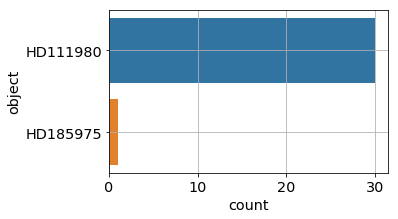

In [41]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel_obs)
plt.grid(True)

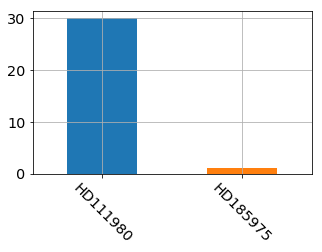

In [42]:
plt.figure(figsize=(5,3))
sel_obs['object'].value_counts().plot(kind='bar',rot=0)
plt.xticks(rotation=-45)
plt.grid(True)

### Remove bad sources

- remove star **PNG336.3-05.6**

In [43]:
bad_obs=sel_obs.loc[sel_obs['object'].isin(['PNG336.3-05.6'])]
bad_indexes=bad_obs["index"]

In [44]:
bad_obs

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,


In [45]:
bad_indexes=bad_obs.loc[:,"index"]

In [46]:
bad_indexes.index

Index([], dtype='object', name=u'date')

In [47]:
bad_indexes.values

array([], dtype=int64)

- keep stars **HD111980**, **HD205905**

In [48]:
sel2_obs=sel_obs.loc[sel_obs['object'].isin(['HD111980','HD185975'])]

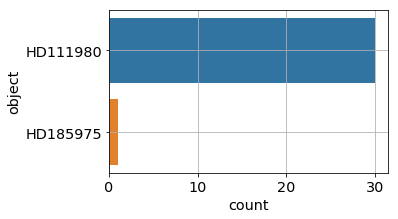

In [49]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel2_obs)
plt.grid(True)

#### Make a list of the object names

In [50]:
list_of_objects=sel2_obs['object'].values

In [51]:
list_of_objects=set(list_of_objects)

In [52]:
list_of_objects=list(list_of_objects)

In [53]:
list_of_objects_str=','.join(list_of_objects)

# Remove bad indexes

In [54]:
file_toremove=[]
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_spectrafiles:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_spectrafiles.remove(f)        

# which filters

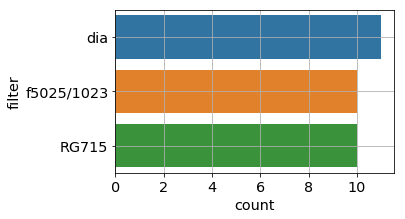

In [55]:
plt.figure(figsize=(5,3))
sns.countplot(y='filter', data=sel2_obs)
plt.grid(True)

# which are the dispersers ?

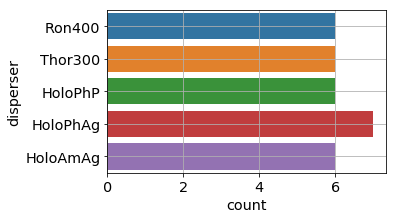

In [56]:
plt.figure(figsize=(5,3))
sns.countplot(y='disperser', data=sel2_obs)
plt.grid(True)

In [57]:
sel_obs_Ron400=sel2_obs.loc[sel2_obs['disperser'].isin(['Ron400'])]

In [58]:
sel_obs_Thor300=sel2_obs.loc[sel2_obs['disperser'].isin(['Thor300'])]

In [59]:
sel_obs_HoloPhP=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloPhP'])]

In [60]:
sel_obs_HoloPhAg=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloPhAg'])]

In [61]:
sel_obs_HoloAmAg=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloAmAg'])]

# Associate Hologram observation to each Ronchi observation

In [62]:
sel_obs_Ron400.head()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-30T00:07:29.654,48,779,4,48,"1,049","1,199",60,HD111980,dia,Ron400,12400,"13,1",data_29may17,reduc_20170529_048.fits
2017-05-30T00:09:13.188,49,779,"3,9",48,"1,048","1,22",60,HD111980,dia,Ron400,12400,"9,3",data_29may17,reduc_20170529_049.fits
2017-05-30T00:49:09.750,60,779,4,48,"1,023","0,976",300,HD111980,f5025/1023,Ron400,12500,"19,9",data_29may17,reduc_20170529_060.fits
2017-05-30T00:54:53.282,61,779,4,48,"1,022","1,08",300,HD111980,f5025/1023,Ron400,12500,"14,9",data_29may17,reduc_20170529_061.fits
2017-05-30T02:20:25.752,72,779,"3,4",43,"1,067","1,358",180,HD111980,RG715,Ron400,12500,"9,6",data_29may17,reduc_20170529_072.fits


In [63]:
sel_obs_HoloPhP.head()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-30T00:14:41.448,52,779,"4,1",47,"1,043","1,336",60,HD111980,dia,HoloPhP,12400,"8,7",data_29may17,reduc_20170529_052.fits
2017-05-30T00:16:24.973,53,779,"4,1",47,"1,041","1,186",60,HD111980,dia,HoloPhP,12400,"10,7",data_29may17,reduc_20170529_053.fits
2017-05-30T01:12:22.148,64,779,"3,9",47,"1,021","1,143",300,HD111980,f5025/1023,HoloPhP,12500,"17,8",data_29may17,reduc_20170529_064.fits
2017-05-30T01:18:05.675,65,779,"3,9",49,"1,022","0,923",300,HD111980,f5025/1023,HoloPhP,12500,"22,7",data_29may17,reduc_20170529_065.fits
2017-05-30T02:35:37.347,76,779,"3,3",44,"1,089","1,537",180,HD111980,RG715,HoloPhP,12500,"9,2",data_29may17,reduc_20170529_076.fits


In [64]:
sel_obs_HoloPhAg.head()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-30T00:18:17.258,54,779,4,47,"1,04","1,148",120,HD111980,dia,HoloPhAg,12400,10,data_29may17,reduc_20170529_054.fits
2017-05-30T00:21:00.613,55,779,"4,1",47,"1,037","1,042",120,HD111980,dia,HoloPhAg,12400,"11,5",data_29may17,reduc_20170529_055.fits
2017-05-30T01:23:58.048,66,779,"3,8",48,"1,023","1,146",600,HD111980,f5025/1023,HoloPhAg,12500,"20,1",data_29may17,reduc_20170529_066.fits
2017-05-30T01:34:41.392,67,779,"3,7",47,"1,027","1,053",600,HD111980,f5025/1023,HoloPhAg,12500,"18,7",data_29may17,reduc_20170529_067.fits
2017-05-30T02:43:12.845,78,779,"3,4",42,"1,102","1,39",360,HD111980,RG715,HoloPhAg,12500,"8,9",data_29may17,reduc_20170529_078.fits


In [65]:
sel_obs_HoloAmAg.head()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-30T00:23:52.749,56,779,"4,1",47,"1,035","1,196",120,HD111980,dia,HoloAmAg,12400,"14,4",data_29may17,reduc_20170529_056.fits
2017-05-30T00:26:36.272,57,779,"4,1",47,"1,033","1,033",120,HD111980,dia,HoloAmAg,12400,"15,1",data_29may17,reduc_20170529_057.fits
2017-05-30T01:45:34.301,68,779,"3,8",44,"1,033","1,132",600,HD111980,f5025/1023,HoloAmAg,12500,"18,3",data_29may17,reduc_20170529_068.fits
2017-05-30T01:56:17.656,69,779,"3,6",43,"1,041","1,132",600,HD111980,f5025/1023,HoloAmAg,12500,"17,2",data_29may17,reduc_20170529_069.fits
2017-05-30T02:56:48.654,80,779,"3,4",41,"1,128","2,524",360,HD111980,RG715,HoloAmAg,12500,"14,1",data_29may17,reduc_20170529_080.fits


In [66]:
def GetClosestTimeObservation(timestamp0,df_ref):
    """
    for a given timestamp find the closest observation in df_ref
    """ 
    # decode the time form timestamp
    year0=timestamp0.year
    month0=timestamp0.month
    day0=timestamp0.days_in_month
    hour0=timestamp0.hour
    minu0=timestamp0.minute
    
    # convert the string into timestamp in the reference dataset
    #-------------------------------------
    all_datetime=pd.to_datetime(df_ref.index.get_values())

    # get time difference between timestamp = timestamp0-time in reference dataset
    #---------------------------------------
    deltat=(all_datetime-timestamp0).total_seconds()
    delays=np.abs(deltat)
    
    #print delays
    
    idx=np.where(delays==delays.min())[0][0]
        
    #print 'deltat :' ,deltat[idx], pd.Timedelta(deltat[idx],unit='s')
    #print df_ref.iloc[idx,:]
        
    #return a pandas series
    return df_ref.iloc[idx,:]

In [67]:
if 0:
    for time_index, row in sel_obs_HoloPhP.iterrows():    
        print 'Holo :' ,time_index,row["index"]
        ref_obs=GetClosestTimeObservation(pd.to_datetime(time_index),sel_obs_Ron400)
       
        print '\t ==> Ron reference obs :',ref_obs.name,' ' ,ref_obs["index"]

In [68]:
def GetReferenceIndexes(dataset,dataset_ref):
    """
    function : GetReferenceIndexes(dataset,dataset_ref)
    
    For all observations in dataset, find the corresponding observations in the reference dataset in dataset_ref
    input:
        dataset : dataset for which one want to find the reference in the other dataset
        dataset_ref : dataset of reference (Here the Ronchi)
    output:
        zipped indexes of both datasets
    
    """
    all_indexes=[]
    all_indexes_ref=[]
    
    for time_index, row in dataset.iterrows():    
        #print 'Holo :' ,time_index,row["index"]
        all_indexes.append(row["index"])
    
        ref_obs=GetClosestTimeObservation(pd.to_datetime(time_index),dataset_ref)
        #print '\t ==> Ron reference obs :',ref_obs.name,' ' ,ref_obs["index"]
        all_indexes_ref.append(ref_obs["index"])
    
    all_indexes=np.array(all_indexes)
    all_indexes_ref=np.array(all_indexes_ref)
    
    return zip(all_indexes,all_indexes_ref)

# Find the closest observations in the reference dataset

## Make index pairs

In [69]:
Thor_Ron_indexes=GetReferenceIndexes(sel_obs_Thor300,sel_obs_Ron400)

In [70]:
HoloPhP_Ron_indexes=GetReferenceIndexes(sel_obs_HoloPhP,sel_obs_Ron400)

In [71]:
HoloPhAg_Ron_indexes=GetReferenceIndexes(sel_obs_HoloPhAg,sel_obs_Ron400)

In [72]:
HoloAmAg_Ron_indexes=GetReferenceIndexes(sel_obs_HoloAmAg,sel_obs_Ron400)

## Make time delay 

In [73]:
all_datetime_Thor=pd.to_datetime(sel_obs_Thor300.index.get_values())
all_deltatime_Thor=(all_datetime_Thor-all_datetime_Thor[0]).total_seconds()

In [74]:
all_datetime_HoloPhP=pd.to_datetime(sel_obs_HoloPhP.index.get_values())
all_deltatime_HoloPhP=(all_datetime_HoloPhP-all_datetime_HoloPhP[0]).total_seconds()

In [75]:
all_datetime_HoloPhAg=pd.to_datetime(sel_obs_HoloPhAg.index.get_values())
all_deltatime_HoloPhAg=(all_datetime_HoloPhAg-all_datetime_HoloPhAg[0]).total_seconds()

In [76]:
all_datetime_HoloAmAg=pd.to_datetime(sel_obs_HoloAmAg.index.get_values())
all_deltatime_HoloAmAg=(all_datetime_HoloAmAg-all_datetime_HoloAmAg[0]).total_seconds()

# Show the ratio

In [77]:
def PlotSpectraRatio(the_index_pair,the_sel_obs,time_color,the_title,YMIN,YMAX,figfilename):
    """
    Function PlotSpectraRatio(the_index_pair,the_sel_obs,the_title,time_color)
    
    input:
        the_index_pair : index pairs
        the_sel_obs    : the logbook
        the_title      : title of the plot 
        time_color     : time in seconds used for color
    
    """    
    
    jet = cm = plt.get_cmap('jet') 
    cNorm  = colors.Normalize(vmin=time_color[0], vmax=time_color[-1])
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    #print scalarMap.get_clim()
    
    plt.figure(figsize=(20,20))
    # loop on indexes paris
    
    idx=0
    
    for idx1,idx2 in the_index_pair:
    
        df1=the_sel_obs[sel_obs["index"]==idx1]
        df2=the_sel_obs[sel_obs["index"]==idx2]
        
        filename1=df1.get_value(df1.index[0],"file")  # get "reduc_20170530_213.fits"
        filename2=df2.get_value(df2.index[0],"file")
        
        filename1_cut=filename1.split('.')[0]         # get "reduc_20170530_213
        filename2_cut=filename2.split('.')[0]
        
        filename1=filename1_cut+'_spectrum.fits'
        filename2=filename2_cut+'_spectrum.fits'
        
        #print idx1,idx2,filename1,filename2
        
        #filename1=filename1.replace('reduc','specsim')
        #filename2=filename2.replace('reduc','specsim')
        
    
        ffilename1=os.path.join(path_spectra,filename1)
        ffilename2=os.path.join(path_spectra,filename2)
       
        #print idx1,idx2,ffilename1,ffilename2
    
        hdu1 = fits.open(ffilename1)
        data1=hdu1[0].data
        wl1=data1[0]
        fl1=data1[1]
            
        # extend range for (wl1,fl1)
        wl1=np.insert(wl1,0,WL[0])
        fl1=np.insert(fl1,0,0.)
            
        wl1=np.append(wl1,WL[-1])
        fl1=np.append(fl1,0.)
        func1 = interpolate.interp1d(wl1, fl1)
            
        hdu2 = fits.open(ffilename2)
        data2=hdu2[0].data
        wl2=data2[0]
        fl2=data2[1]
        
        # extend range for (wl2,fl2)
        wl2=np.insert(wl2,0,WL[0])
        fl2=np.insert(fl2,0,0.)
        wl2=np.append(wl2,WL[-1])
        fl2=np.append(fl2,0.)
            
        func2 = interpolate.interp1d(wl2, fl2)
        
        fl1_int=func1(WL)
        fl2_int=func2(WL)
        
        the_label=str(idx1)+'/'+str(idx2)
        
        colorVal = scalarMap.to_rgba(time_color[idx])
        
        plt.plot(WL,2.5*np.log10(fl1_int/fl2_int),lw=2,color=colorVal,label=the_label)
        
        idx+=1
        
    plt.grid()    
    plt.title(the_title,fontsize=30,fontweight='bold')
    plt.xlabel("$\lambda$ (nm)", fontsize=25,fontweight='bold')   
    plt.ylabel("log10(spectra ratio)",fontsize=25,fontweight='bold' )
    plt.ylim(YMIN,YMAX)
    # We change the fontsize of minor ticks label 
    plt.tick_params(axis='both', which='major', labelsize=25)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.legend()
    plt.savefig(figfilename)

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:28: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:29: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in divide
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in log10


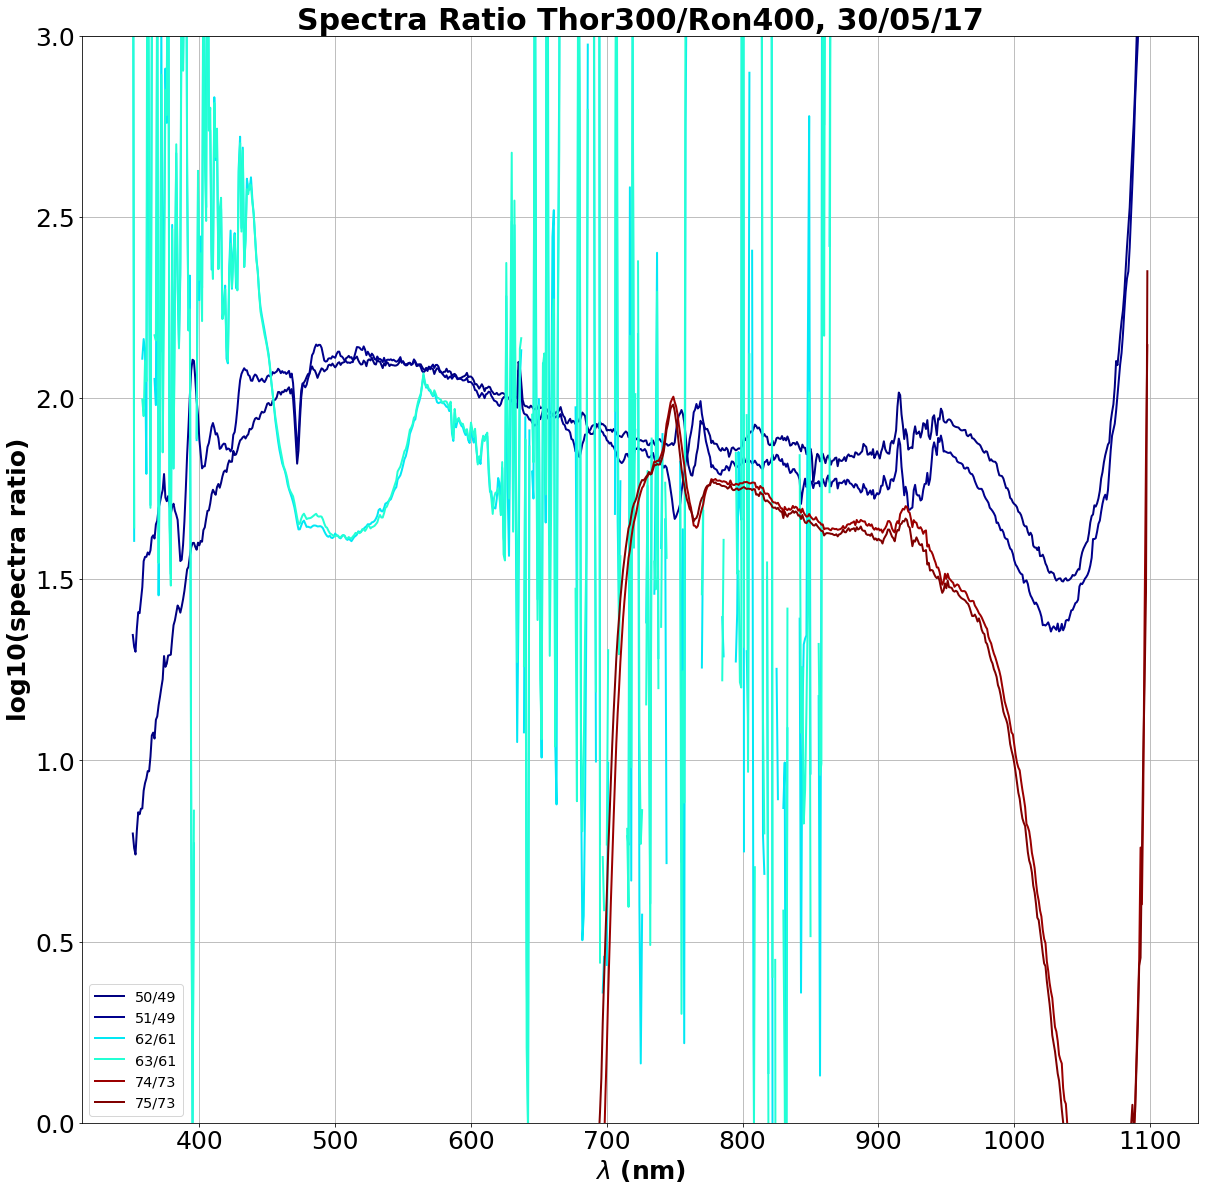

In [78]:
PlotSpectraRatio(Thor_Ron_indexes,sel2_obs,all_deltatime_Thor,
                 "Spectra Ratio Thor300/Ron400, 30/05/17",YMIN=0,YMAX=3,figfilename='Thor300DivRon400.pdf')

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:28: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:29: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in divide
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in log10


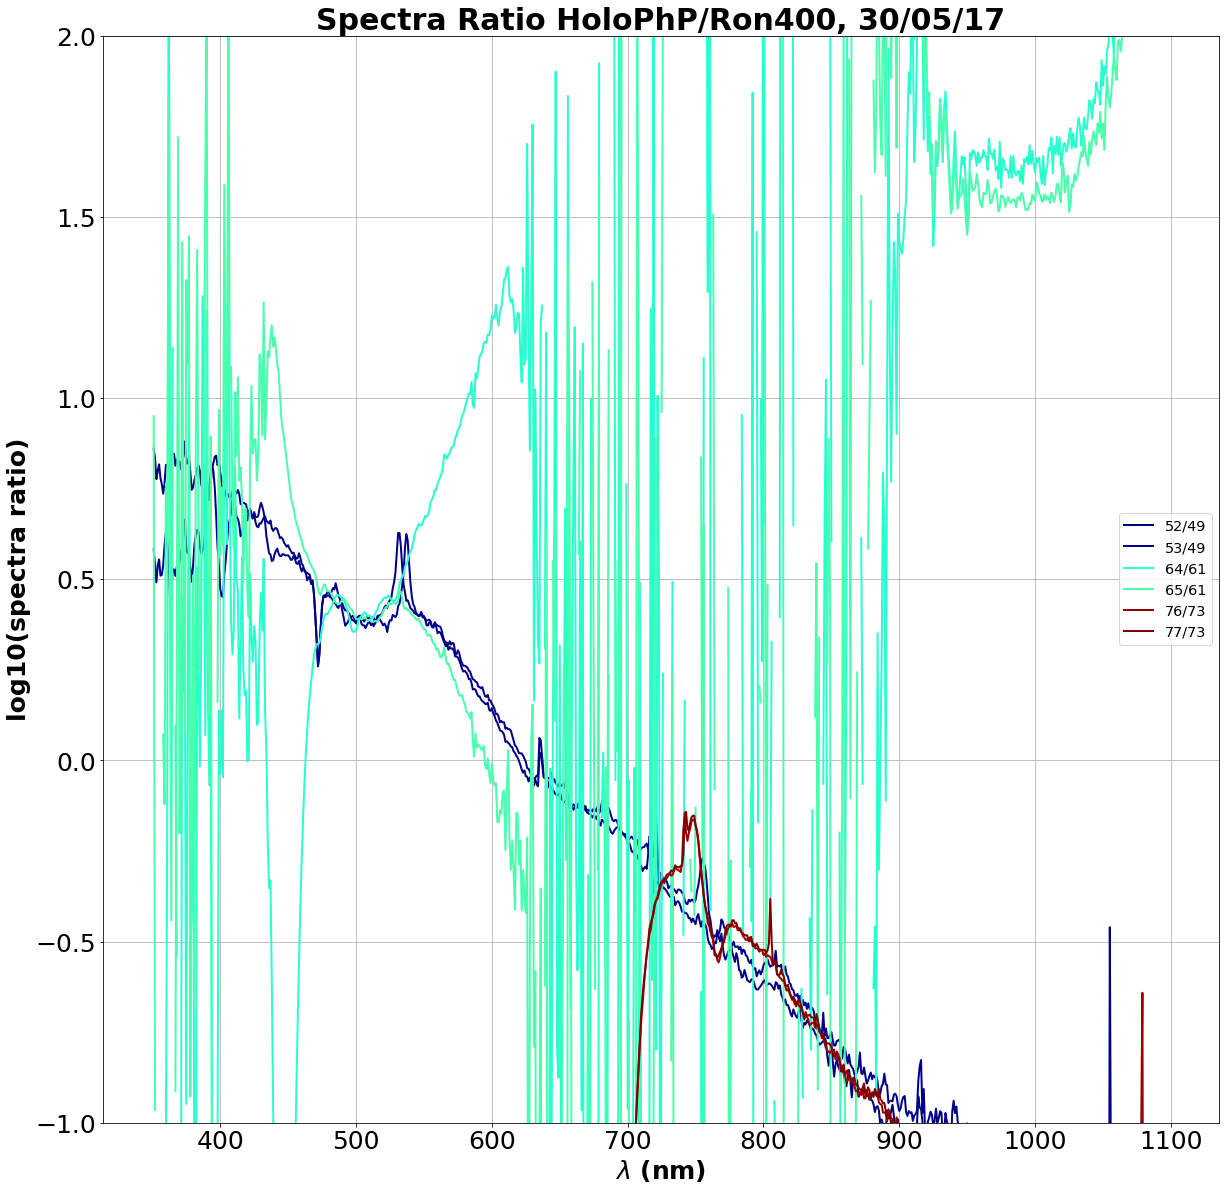

In [79]:
PlotSpectraRatio(HoloPhP_Ron_indexes,sel2_obs,all_deltatime_HoloPhP,
                 "Spectra Ratio HoloPhP/Ron400, 30/05/17",YMIN=-1,YMAX=2,figfilename='HoloPhPDivRon400.pdf')

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:28: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:29: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in divide
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in log10


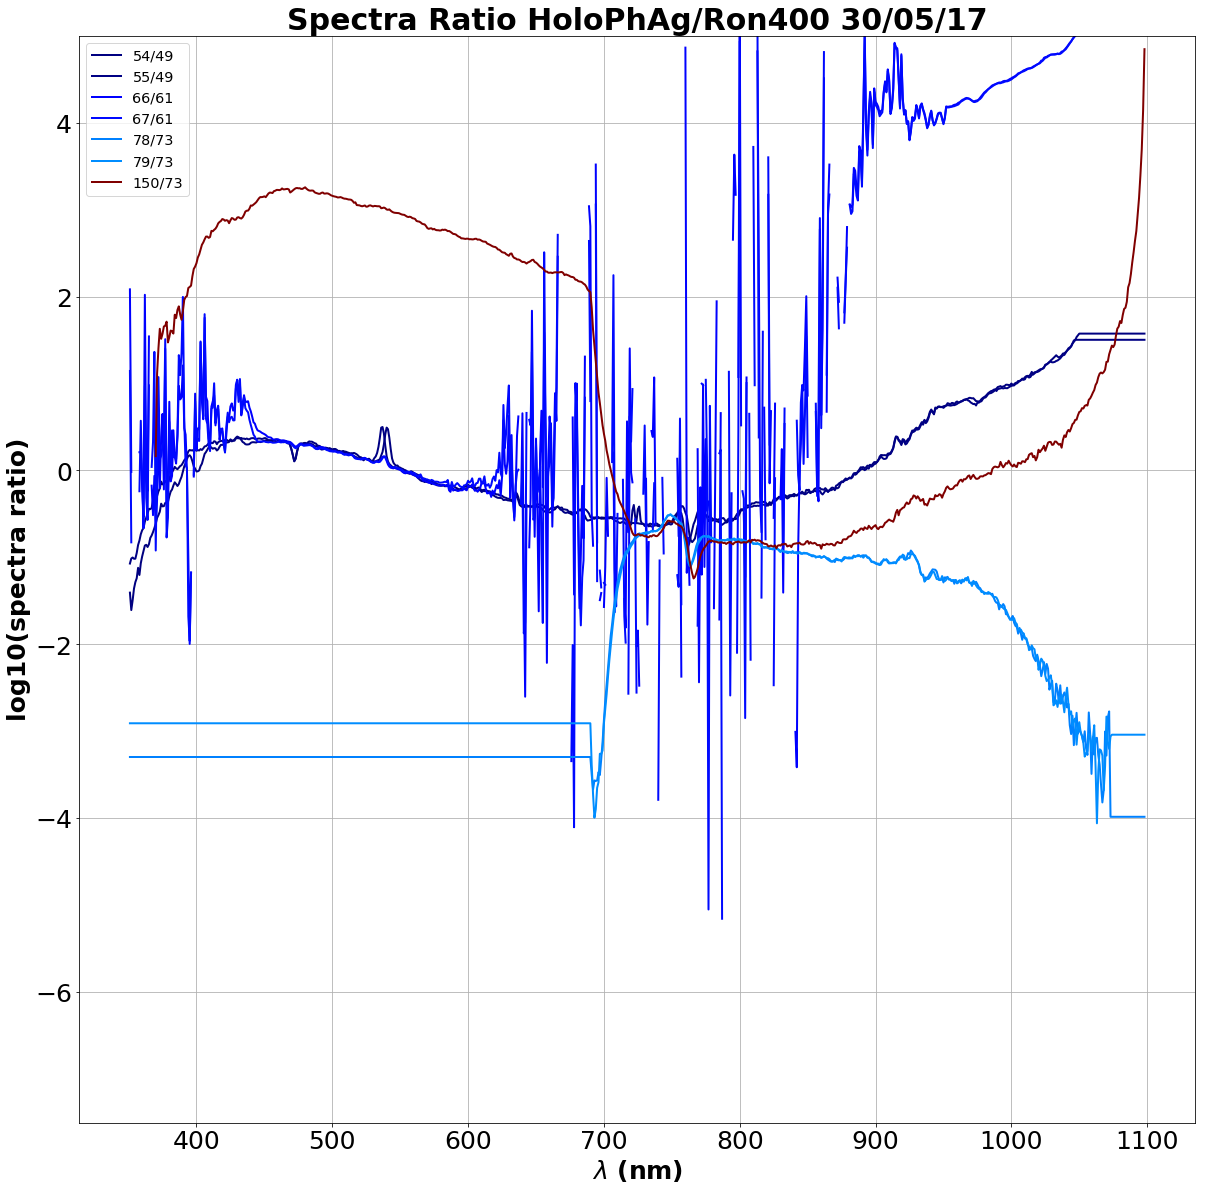

In [80]:
PlotSpectraRatio(HoloPhAg_Ron_indexes,sel2_obs,all_deltatime_HoloPhAg,
                 "Spectra Ratio HoloPhAg/Ron400 30/05/17",YMIN=-7.5,YMAX=5,figfilename='HoloPhAgDivRon400.pdf')

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:28: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:29: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in divide
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in log10


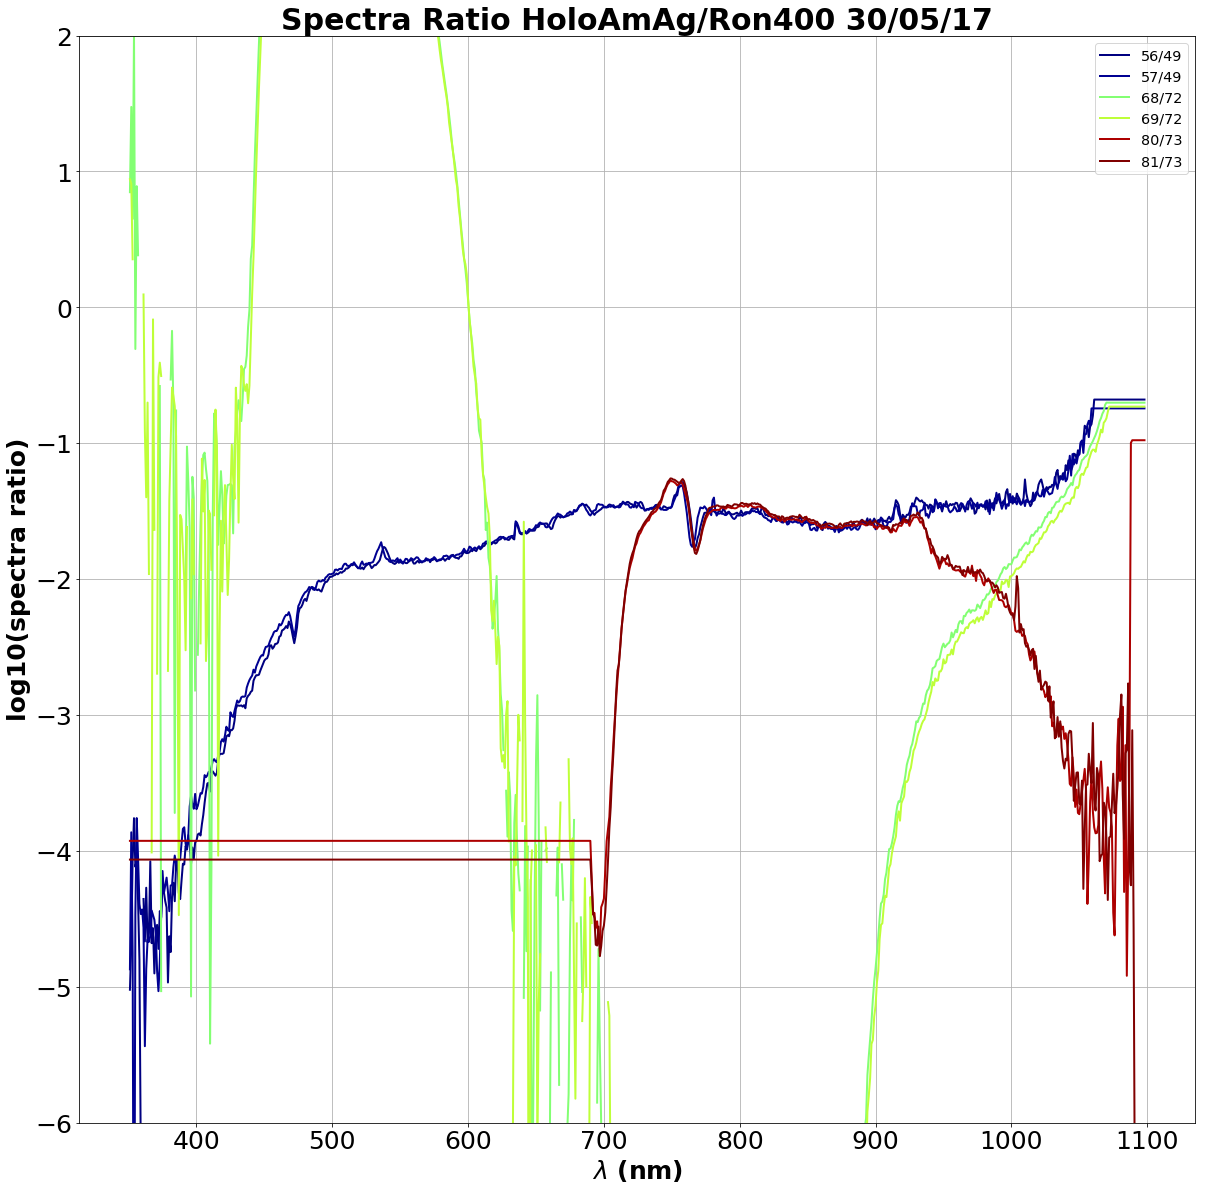

In [81]:
PlotSpectraRatio(HoloAmAg_Ron_indexes,sel2_obs,all_deltatime_HoloAmAg,
                 "Spectra Ratio HoloAmAg/Ron400 30/05/17",YMIN=-6,YMAX=2,figfilename='HoloAmAgDivRon400.pdf')